In [1]:
import pandas as pd
import numpy as np
import torch
import importlib
from utils.utils_dataset import prepare_k_fold_non_iid_dataset, plot_dataset_split, display_dataset_split
from sklearn import datasets
from sklearn.model_selection import KFold
from utils.utils_train import train_supervised, test_model
from utils.utils_plots import plot_first_feature_horizontal, save_figure
from utils.utils_metrics import calculate_metrics_statistics, calculate_cluster_stats, calculate_metrics, plot_confusion_matrix


In [2]:
from model.eGauss_plus import eGAUSSp

print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)

# Check if CUDA is available
#if torch.cuda.is_available():
    #device = torch.device("cuda")
    #print("CUDA is available. Using GPU.")
#else:
device = torch.device("cpu")
print("CUDA not available. Using CPU.")

# Model parameters
local_model_params = {
    "feature_dim": 4,
    "num_classes": 3,
    "kappa_n": 2,
    "num_sigma": 2,
    "kappa_join": 1.0,
    "S_0": 1e-8,
    "N_r": 3,
    "c_max": 100,
    "device": device
}
federated_model_params = {
    "feature_dim": 4,
    "num_classes": 3,
    "kappa_n": 2,
    "num_sigma": 10,
    "kappa_join": 2,
    "S_0": 1e-8,
    "N_r": 3,
    "c_max": 100,
    "device": device
}

PyTorch Version: 2.1.1
CUDA Version: None
CUDA not available. Using CPU.



*** Start of fold 0. ***

Training model for client 1
Evolving has been enabled.

Testing model for client 1
Evolving has been disabled.
Test Metrics: {'accuracy': 0.6666666666666666, 'precision': 0.5515151515151515, 'recall': 0.6666666666666666, 'f1_score': 0.5786492374727669}
Number of clusters with multiple samples for Client 1 = 5

Training model for client 2
Evolving has been enabled.

Testing model for client 2
Evolving has been disabled.
Test Metrics: {'accuracy': 0.6666666666666666, 'precision': 0.4848484848484848, 'recall': 0.6666666666666666, 'f1_score': 0.5490196078431372}
Number of clusters with multiple samples for Client 2 = 4

Training model for client 3
Evolving has been enabled.

Testing model for client 3
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics: {'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8, 'f1_score': 0.8}
Number of clusters with multiple samples for Client 3 = 7

Training model for client 4
Evolving has been enabled.

Testing model for client 4
Evolving has been disabled.
Test Metrics: {'accuracy': 0.7666666666666667, 'precision': 0.8627450980392157, 'recall': 0.7666666666666667, 'f1_score': 0.748874364560639}
Number of clusters with multiple samples for Client 4 = 6

Number of clusters after transfer = 3

Number of clusters after transfer = 6

Number of clusters after transfer = 11

Number of clusters after transfer = 16
Number of clusters after merging = 3

Testing federated model
Evolving has been disabled.
Test Metrics: {'accuracy': 0.8333333333333334, 'precision': 0.8529914529914531, 'recall': 0.8333333333333334, 'f1_score': 0.8322981366459626}

*** Start of fold 1. ***

Training model for client 1
Evolving has been enabled.

Testing model for client 1
Evolving has been disabled.
Test Metrics: {'accur

c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics: {'accuracy': 0.5666666666666667, 'precision': 0.415, 'recall': 0.5666666666666667, 'f1_score': 0.454320987654321}
Number of clusters with multiple samples for Client 2 = 2

Training model for client 3
Evolving has been enabled.

Testing model for client 3
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9666666666666667, 'precision': 0.9690476190476189, 'recall': 0.9666666666666667, 'f1_score': 0.9660018993352326}
Number of clusters with multiple samples for Client 3 = 7

Training model for client 4
Evolving has been enabled.

Testing model for client 4
Evolving has been disabled.
Test Metrics: {'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8, 'f1_score': 0.8}
Number of clusters with multiple samples for Client 4 = 9

Number of clusters after transfer = 3

Number of clusters after transfer = 4

Number of clusters after transfer = 11

Number of clusters after transfer = 16
Number of clusters after merging = 3

Testing federated model
Evolving has been disabled.
Te

c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics: {'accuracy': 0.8333333333333334, 'precision': 0.8974358974358975, 'recall': 0.8333333333333334, 'f1_score': 0.8333333333333334}
Number of clusters with multiple samples for Client 4 = 5

Number of clusters after transfer = 2

Number of clusters after transfer = 4

Number of clusters after transfer = 8

Number of clusters after transfer = 13
Number of clusters after merging = 3

Testing federated model
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9666666666666667, 'precision': 0.9703703703703703, 'recall': 0.9666666666666667, 'f1_score': 0.9669803921568627}

*** Start of fold 3. ***

Training model for client 1
Evolving has been enabled.

Testing model for client 1
Evolving has been disabled.
Test Metrics: {'accuracy': 0.23333333333333334, 'precision': 0.05444444444444444, 'recall': 0.23333333333333334, 'f1_score': 0.08828828828828827}
Number of clusters with multiple samples for Client 1 = 8

Training model for client 2
Evolving has been enabled.

Testing mode

c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics: {'accuracy': 0.8, 'precision': 0.88, 'recall': 0.8, 'f1_score': 0.7780864197530865}
Number of clusters with multiple samples for Client 3 = 8

Training model for client 4
Evolving has been enabled.

Testing model for client 4
Evolving has been disabled.
Test Metrics: {'accuracy': 0.8333333333333334, 'precision': 0.8375, 'recall': 0.8333333333333334, 'f1_score': 0.8339869281045751}
Number of clusters with multiple samples for Client 4 = 5

Number of clusters after transfer = 3

Number of clusters after transfer = 6

Number of clusters after transfer = 12

Number of clusters after transfer = 16
Number of clusters after merging = 3

Testing federated model
Evolving has been disabled.
Test Metrics: {'accuracy': 0.8666666666666667, 'precision': 0.9076923076923077, 'recall': 0.8666666666666667, 'f1_score': 0.8521212121212121}

*** Start of fold 4. ***

Training model for client 1
Evolving has been enabled.

Testing model for client 1
Evolving has been disabled.
Test Metrics: {'

c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\eGaussP\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Testing model for client 2
Evolving has been disabled.
Test Metrics: {'accuracy': 0.7666666666666667, 'precision': 0.611111111111111, 'recall': 0.7666666666666667, 'f1_score': 0.6733333333333335}
Number of clusters with multiple samples for Client 2 = 4

Training model for client 3
Evolving has been enabled.

Testing model for client 3
Evolving has been disabled.
Test Metrics: {'accuracy': 0.5666666666666667, 'precision': 0.8483333333333333, 'recall': 0.5666666666666667, 'f1_score': 0.4832098765432099}
Number of clusters with multiple samples for Client 3 = 8

Training model for client 4
Evolving has been enabled.

Testing model for client 4
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9333333333333333, 'precision': 0.9333333333333333, 'recall': 0.9333333333333333, 'f1_score': 0.9333333333333333}
Number of clusters with multiple samples for Client 4 = 6

Number of clusters after transfer = 1

Number of clusters after transfer = 5

Number of clusters after transfer = 10

Nu

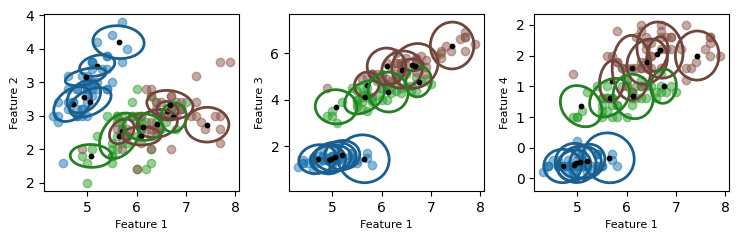

Figure saved as Images/iris_federated_pre_merge.svg in svg format.
Figure saved as Images/iris_federated_pre_merge.pdf in pdf format.
Number of clusters after merging = 3

Testing federated model
Evolving has been disabled.
Test Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}


In [3]:
# Load the Iris dataset
iris = datasets.load_iris()

X = iris.data
y = iris.target

num_clients = 4
num_splits = 5

kf = KFold(n_splits=num_splits, shuffle=True, random_state=None)  

# Initialize arrays to track samples per class for each client in each fold
samples_per_class_per_client = np.zeros((num_clients, local_model_params["num_classes"], num_splits))

# Main loop for k-fold cross-validation
all_client_metrics = [[] for _ in range(num_clients)]
all_client_clusters = [[] for _ in range(num_clients)]

all_federated_metrics = []
all_federated_clusters = []

for i_fold, (train_index, test_index) in enumerate(kf.split(iris.data)):
    print(f"\n*** Start of fold {i_fold}. ***")
    
    #Split the data
    train_data, test_data, all_data = prepare_k_fold_non_iid_dataset(X, y, train_index, test_index, num_clients)
    
    #Create the models
    local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
    federated_model = eGAUSSp(**federated_model_params)
    #federated_model.toggle_debugging(True)
    
    #Train the models
    for client_idx, client_model in enumerate(local_models):
        
        # Count the number of samples per class for this client in this fold
        for class_idx in range(client_model.num_classes):
            class_samples = torch.sum(train_data[client_idx][1] == class_idx)
            samples_per_class_per_client[client_idx, class_idx, i_fold] = class_samples

        #Supervised clustering
        print(f"\nTraining model for client {client_idx + 1}")
        train_supervised(client_model, train_data[client_idx]) 

        #Test the local models
        print(f"\nTesting model for client {client_idx + 1}")
        _, pred, _ = test_model(client_model, test_data)
        metrics = calculate_metrics(pred, test_data, "weighted")
        print(f"Test Metrics: {metrics}")
        all_client_metrics[client_idx].append(metrics)

        #Save the number of clusters
        num_client_clusters = torch.sum(client_model.n[:client_model.c] > 1).item()
        print(f"Number of clusters with multiple samples for Client {client_idx + 1} = {num_client_clusters}")
        all_client_clusters[client_idx].append(num_client_clusters)

    #Aggregate local models
    for client_model in local_models:
        federated_model.federal_agent.merge_model_privately(client_model, federated_model.kappa_n)
        #Merge the federated model clusters
        print(f"\nNumber of clusters after transfer = {federated_model.c}")

    #Plot the Aggregated model
    if i_fold == (num_splits-1):
        fig = plot_first_feature_horizontal(all_data, model=federated_model, num_sigma=2, N_max=0, title="",format='%d')   
        save_figure(fig, "Images/iris_federated_pre_merge.svg","svg")
        save_figure(fig, "Images/iris_federated_pre_merge.pdf","pdf")

    federated_model.federal_agent.federated_merging()

    num_federated_clusters = torch.sum(federated_model.n[:federated_model.c] > 0).item()
    print(f"Number of clusters after merging = {federated_model.c}")
    
    #Test the federated model
    print(f"\nTesting federated model")
    _, pred_fed, _ = test_model(federated_model, test_data)
    federated_metrics = calculate_metrics(pred_fed, test_data, "weighted")
    print(f"Test Metrics: {federated_metrics}")
    all_federated_metrics.append(federated_metrics)
    all_federated_clusters.append(num_federated_clusters)

In [7]:
# Calculate the average number of samples per class for each client and print the results
average_samples_per_class_per_client = np.mean(samples_per_class_per_client, axis=2)
print("Average samples per class for each client:")
for client_idx, avg_samples in enumerate(average_samples_per_class_per_client):
    formatted_avg_samples = [f"{sample:.2f}" for sample in avg_samples]
    print(f"Client {client_idx + 1}: {formatted_avg_samples}")

# Calculate and display formatted metrics for each client
for client_idx, client_metrics in enumerate(all_client_metrics):
    formatted_metrics = calculate_metrics_statistics(client_metrics)
    print(f"\nMetrics for Client {client_idx + 1} (mean ± std):")
    for metric, formatted_value in formatted_metrics.items():
        print(f"{metric}: {formatted_value}")

# Calculate and display evaluation metrics for the federated model
avg_std_federated_metrics = calculate_metrics_statistics(all_federated_metrics)
print("\nFederated Model - Metrics (mean ± std):")
for metric, formatted_value in avg_std_federated_metrics.items():
    print(f"{metric}: {formatted_value}")

# Compute and display cluster statistics for each client
for client_idx, client_clusters in enumerate(all_client_clusters):
    avg_clusters, std_clusters = calculate_cluster_stats(client_clusters)
    print(f"\nClient {client_idx + 1} - Average Number of Clusters (mean ± std): {avg_clusters:.2f} ± {std_clusters:.2f}")

# Compute and display cluster statistics for the federated model
avg_fed_clusters, std_fed_clusters = calculate_cluster_stats(all_federated_clusters)
print(f"\nFederated Model - Average Number of Clusters (mean ± std): {avg_fed_clusters:.2f} ± {std_fed_clusters:.2f}")


Average samples per class for each client:
Client 1: ['0.00', '9.60', '9.60']
Client 2: ['20.00', '0.00', '12.20']
Client 3: ['8.80', '21.00', '8.80']
Client 4: ['11.20', '9.40', '9.40']


AttributeError: 'str' object has no attribute 'keys'

In [8]:
#Create a latex table for the paper
# Start the LaTeX table code
latex_table = r"""\begin{table}[ht]
\centering
\setlength{\tabcolsep}{4pt}
\scriptsize
\caption{Performance metrics and average number of clusters on the Iris dataset.}
\label{tab:performance_clusters}
\begin{tabular}{lcccccc}
\toprule
\textbf{Metric} & \textbf{Client 1} & \textbf{Client 2} & \textbf{Client 3} & \textbf{Client 4} & \textbf{Federated} \\
"""

# Add the average samples per class for each client
samples_row = ""
for samples in average_samples_per_class_per_client:
    samples_row += " & " + "/".join([f"{x:.1f}" if x != 0 else "0" for x in samples])
latex_table += samples_row + " & \\\\" + "\n"

latex_table += r"\midrule" + "\n"
# Add rows for each metric
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
metric_names = ['accuracy', 'precision', 'recall', 'f1 score']
for i, metric in enumerate(metrics):
    row = metric_names[i].capitalize() + r' $\uparrow$'
    for client_metrics in all_client_metrics:
        formatted_metric = calculate_metrics_statistics(client_metrics)[metric]
        row += f' & {formatted_metric}'
    fed_formatted_metric = calculate_metrics_statistics(all_federated_metrics)[metric]
    row += r' & \bf'+f'{{{fed_formatted_metric}}}'
    latex_table += row + r' \\' + '\n'

# Add row for clusters
cluster_row = r'\#Clusters $\downarrow$'
for client_clusters in all_client_clusters:
    avg_clusters, std_clusters = calculate_cluster_stats(client_clusters)
    cluster_row += f' & {avg_clusters:.1f} ± {std_clusters:.1f}'
avg_fed_clusters, std_fed_clusters = calculate_cluster_stats(all_federated_clusters)
cluster_row += r' & \bf'+f'{{{avg_fed_clusters:.1f} ± {std_fed_clusters:.1f}}}'
latex_table += cluster_row + r' \\' + '\n'

# End the LaTeX table code
latex_table += r"""\bottomrule
\end{tabular}
\end{table}
"""

# Print the complete LaTeX table
print(latex_table)


AttributeError: 'str' object has no attribute 'keys'

In [ ]:
#Aditional plots of the data
display_dataset_split(train_data, test_data)
fig = plot_dataset_split(train_data, test_data)
save_figure(fig, "Images/iris_data_distribution.svg","svg")

In [ ]:
#Plot of the last local model
fig = plot_first_feature_horizontal(train_data[client_idx], model=client_model, num_sigma=2, N_max=1, title="",format='%d', legend = True, data_name = "Class")  
save_figure(fig, "Images/iris_local_model.svg", "svg")
save_figure(fig, "Images/iris_local_model.pdf","pdf")

In [ ]:
#Plot of the last federated model
fig = plot_first_feature_horizontal(test_data, model=federated_model, num_sigma=2, N_max=0, title="", format='%d')   
print(f"Number of clusters after merging = {federated_model.c}")
save_figure(fig, "Images/iris_federated_merged.svg","svg")
save_figure(fig, "Images/iris_federated_merged.pdf","pdf")

In [ ]:
plot_confusion_matrix(pred_fed, test_data)